In [1]:
import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [2]:
# Задаем данные
target_file_path = "train_target.csv"
file_path = 'train_data'

target_df = pd.read_csv(target_file_path)


table = pq.read_table(file_path)
df = table.to_pandas()

print(f"Обработка файла завершена.")

Обработка файла завершена.


In [3]:
# Смотрим пропуски

print(df.isna().sum())
print('________________________________')

# Пробуем найти даже 1 пропуск, который не видно на графике и можно было бы не заметить при просмотре вывода строки 3-4. 
missing_columns = df.columns[df.isnull().any()]

if missing_columns.empty:
    print("Пропусков нет в данных.")
else:
    print("Пропуски обнаружены в следующих столбцах:")
    for column in missing_columns:
        missing_count = df[column].isnull().sum()
        print(f"{column}: {missing_count} пропусков")
print('________________________________')
# Информация о датафрейме
df.info()
print('________________________________')

df.nunique()

id                         0
rn                         0
pre_since_opened           0
pre_since_confirmed        0
pre_pterm                  0
                          ..
enc_loans_credit_status    0
enc_loans_credit_type      0
enc_loans_account_cur      0
pclose_flag                0
fclose_flag                0
Length: 61, dtype: int64
________________________________
Пропусков нет в данных.
________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26162717 entries, 0 to 26162716
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit    

id                         3000000
rn                              58
pre_since_opened                20
pre_since_confirmed             18
pre_pterm                       18
                            ...   
enc_loans_credit_status          7
enc_loans_credit_type            8
enc_loans_account_cur            4
pclose_flag                      2
fclose_flag                      2
Length: 61, dtype: int64

In [4]:
numeric_columns = df.select_dtypes(include='number')

for column in numeric_columns.columns:
    non_numeric_values = pd.to_numeric(df[column], errors='coerce').isnull()
    if non_numeric_values.any():
        print(f"В колонке {column} содержатся значения, отличные от чисел.")
    else:
        print(f"Все значения численные")

Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значени

In [5]:
selected_features = ['enc_paym_3', 'enc_paym_12', 'enc_paym_24']

# Получаем список столбцов, которые нужно удалить
columns_to_drop = [col for col in df.columns if col.startswith('enc_paym_') and col not in selected_features]

df = df.drop(columns=columns_to_drop)

In [6]:
df = df.drop('pre_since_opened', axis=1)
df = df.drop('pre_since_confirmed', axis=1)
df = df.drop('pre_till_fclose', axis=1)

In [7]:
duplicates = df.duplicated()

# Выводим строки с дубликатами
print("Строки с дубликатами:")
print(df[duplicates])

Строки с дубликатами:
Empty DataFrame
Columns: [id, rn, pre_pterm, pre_fterm, pre_till_pclose, pre_loans_credit_limit, pre_loans_next_pay_summ, pre_loans_outstanding, pre_loans_total_overdue, pre_loans_max_overdue_sum, pre_loans_credit_cost_rate, pre_loans5, pre_loans530, pre_loans3060, pre_loans6090, pre_loans90, is_zero_loans5, is_zero_loans530, is_zero_loans3060, is_zero_loans6090, is_zero_loans90, pre_util, pre_over2limit, pre_maxover2limit, is_zero_util, is_zero_over2limit, is_zero_maxover2limit, enc_paym_3, enc_paym_12, enc_paym_24, enc_loans_account_holder_type, enc_loans_credit_status, enc_loans_credit_type, enc_loans_account_cur, pclose_flag, fclose_flag]
Index: []

[0 rows x 36 columns]


In [8]:
df = df.groupby('id').mean().reset_index()


In [9]:
# Попробуем добавить новый признак, показывающий отсутствие просрочек. 
df['no_delinquencies'] = (df['is_zero_loans530'].astype(bool) & df['is_zero_loans3060'].astype(bool) & df['is_zero_loans90'].astype(bool) & df['is_zero_loans6090'].astype(bool) & df['is_zero_loans5'].astype(bool)).astype(int)

# Выводим результат

In [10]:
# Добавим признак показывающий всего количество просрочек
df['total_delinquencies'] = df['is_zero_loans530'] + df['is_zero_loans3060'] + df['is_zero_loans5'] + df['is_zero_loans90'] + df['is_zero_loans6090']

In [11]:
df = pd.merge(df, target_df[['id', 'flag']], on='id', how='left')
df = df.drop('id', axis=1)
print(f"Объединение файлов завершено.")
parquet_file_path = 'data_mean_first_var.parquet'

# Преобразуем DataFrame в таблицу pyarrow
table = pa.Table.from_pandas(df)

# Сохраняем таблицу в формате Parquet
pq.write_table(table, parquet_file_path)
print(f"Сохранение файла завершено.")

Объединение файлов завершено.
Сохранение файла завершено.


In [12]:
df['flag'].value_counts()

flag
0    2893558
1     106442
Name: count, dtype: int64

<Axes: ylabel='count'>

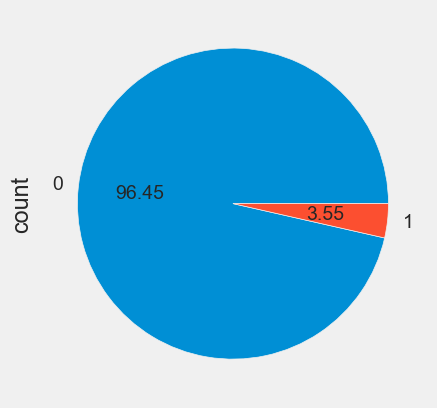

In [13]:
df['flag'].value_counts().plot.pie(autopct='%.2f')

Из графика можно видеть, что доля дефолтных случаев составляет всего 3.55% процента, что подтверждает сильный дизбаланс классов.